<a href="https://colab.research.google.com/github/donghuna/AI-Expert/blob/main/%5BSamsung_AI_Expert_Day2%5D_L2_Word_Embedding_%2B_Neural_LM_(Student).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 1: Word Embedding and Application

#### Step 1: Word Embedding Tutorial
We will use the pre-trained Word2Vec model provided by Google. This model contains vectors for 3 million words and phrases. (In case of network issue: use Glove for lighter model)

In [ ]:
import gensim.downloader as api

# Load pre-trained Word2Vec model (CBOW)
#model = api.load('word2vec-google-news-300')
model = api.load('glove-wiki-gigaword-50')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
# Find words similar to 'computer'
similar_words = model.most_similar('computer', topn=5)
print("Words similar to 'computer':", similar_words)

# Perform word analogy: king - man + woman = ?
result = model.most_similar(positive=['king', 'woman'], negative=['man'], topn=1)
print("Result of analogy 'king - man + woman':", result)

Words similar to 'computer': [('computers', 0.7979379892349243), ('laptop', 0.6640493273735046), ('laptop_computer', 0.6548868417739868), ('Computer', 0.647333562374115), ('com_puter', 0.6082080006599426)]
Result of analogy 'king - man + woman': [('queen', 0.7118193507194519)]


### Visualization via Principal Component Analysis

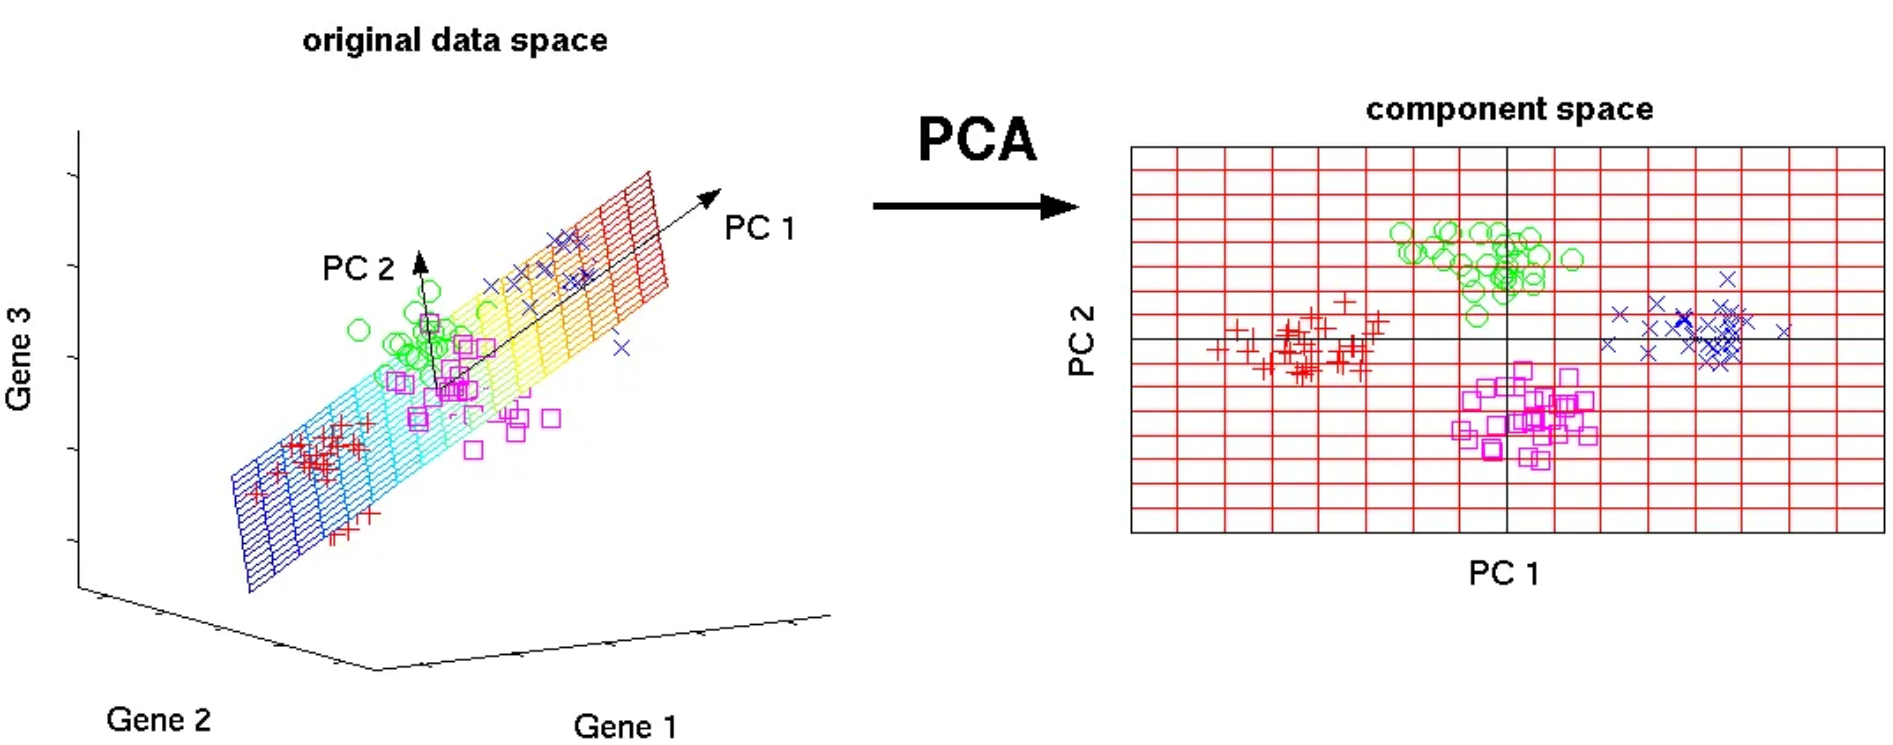

In [ ]:
# Values of Word Vector
print("Word Vector Size:", model.vector_size)
print("Word Vector for 'king':", model['king'])
print("Word Vector for 'queen':", model['queen'])

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Visualization
# Get word vectors
words = ['computer', 'king', 'queen', 'man', 'woman', 'dog', 'cat', 'car', 'bus', 'apple', 'orange']
word_vectors = [model[word] for word in words]

# Reduce dimensions using PCA
pca = PCA(n_components=2)
word_vectors_pca = pca.fit_transform(word_vectors)

# Plot the words
plt.figure(figsize=(10, 10))
plt.scatter(word_vectors_pca[:, 0], word_vectors_pca[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, xy=(word_vectors_pca[i, 0], word_vectors_pca[i, 1]))

plt.title("Word Embedding PCA")
plt.show()

In [ ]:
# Having fun with Word Embedding
# Finding the odd word out
odd_one_out = model.doesnt_match(['breakfast', 'lunch', 'dinner', 'banana'])
print("Odd one out:", odd_one_out)

In [ ]:
# Calculate similarity between two words
similarity = model.similarity('woman', 'man')
print("Similarity between 'woman' and 'man':", similarity)

#### Step 2: Spam Classification with Word Embeddings
Word embeddings such as Word2Vec can be used as a building block of the model for downstream tasks. In this tutorial, we will build a spam mail classifier upon the Word2Vec embeddings.

In [ ]:
!wget -O spam_dataset.tsv https://drive.google.com/uc?id=1GaUS8wMlWQwqhgCX2wsvhOkQ8_Uw_x2r

--2024-06-19 02:06:56--  https://drive.google.com/uc?id=1GaUS8wMlWQwqhgCX2wsvhOkQ8_Uw_x2r
Resolving drive.google.com (drive.google.com)... 74.125.139.113, 74.125.139.102, 74.125.139.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.139.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1GaUS8wMlWQwqhgCX2wsvhOkQ8_Uw_x2r [following]
--2024-06-19 02:06:56--  https://drive.usercontent.google.com/download?id=1GaUS8wMlWQwqhgCX2wsvhOkQ8_Uw_x2r
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.250.98.132, 2607:f8b0:400c:c1a::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.250.98.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5500631 (5.2M) [application/octet-stream]
Saving to: ‘spam_dataset.tsv’

spam_dataset.tsv    100%[===================>]   5.25M  --.-KB/s    in 0.06s   

2024-06-19 02:06:57 (82.1 MB/

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Read dataset
df = pd.read_csv('spam_dataset.tsv', sep="\t")
df

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...,...,...
5166,1518,ham,Subject: put the 10 on the ft\r\nthe transport...,0
5167,404,ham,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,2933,ham,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,1409,ham,Subject: industrial worksheets for august 2000...,0


In [ ]:
from sklearn.model_selection import train_test_split

X = df['text']
y = df['label_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Make document embedding with mean-pooling
def get_embeddings(text_list, model):
    embeddings = []
    for text in text_list:
        words = text.split()
        word_vectors = [model[word] for word in words if word in model]
        if word_vectors:
            embeddings.append(np.mean(word_vectors, axis=0)) # mean pooling
        else:
            embeddings.append(np.zeros(model.vector_size))  # embedding size
    return embeddings

X_train_w2v = get_embeddings(X_train, model)
X_test_w2v = get_embeddings(X_test, model)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_w2v, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_w2v, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(MLP, self).__init__()
        # DIY
        # Hint: use ReLU as activation function


    def forward(self, x):
        # DIY
        out = None # Your code here
        # Your code here
        return out

# Hyperparameters
input_size = model.vector_size
hidden_size = 100
num_classes = 2
num_epochs = 10
learning_rate = 0.001

classifier = MLP(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=learning_rate)

# Training the classifier
for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train_loader):
        outputs = classifier(features)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [ ]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Testing the classifier
classifier.eval()
label_true = []
label_pred = []
with torch.no_grad():
    for features, labels in test_loader:
        outputs = classifier(features) # 32 * 2 (bsz * output_dim)
        print(outputs.shape)
        _, predicted = torch.max(outputs.data, 1) # predicted shape is [32] (_ is max val, predicted is max idx)
        label_true.extend(labels.tolist())
        label_pred.extend(predicted.tolist())


In [ ]:
# Calculate accuracy
accuracy = 0
for i in range(len(label_true)):
    if label_true[i] == label_pred[i]:
        accuracy += 1
accuracy /= len(label_true)
print(f'Accuracy: {100*accuracy:.2f}')

# Calcualte precision
precision = precision_score(label_true, label_pred, average='weighted')
print(f'Precision: {100*precision:.2f}')

# Calculate recall
recall = recall_score(label_true, label_pred, average='weighted')
print(f'Recall: {100*recall:.2f}')

# Calculate F1 score
f1 = f1_score(label_true, label_pred, average='weighted')
print(f'F1 Score: {100*f1:.2f}')

In [ ]:
# Inference example
sentence = "get your free iPhone today!!"
sentence_w2v = get_embeddings([sentence], model)
sentence_tensor = torch.tensor(sentence_w2v, dtype=torch.float32)
with torch.no_grad():
    output = classifier(sentence_tensor)
    _, predicted = torch.max(output.data, 1)

print('sentence:', sentence)
if predicted.item() == 1:
    print('Spam')
else:
    print('Not Spam')

sentence: get your free iPhone today!!
Spam


## Part 2: BERT - Language Modeling and Application


#### Step 1: Model Setup

In this lab session, we use [Huggingface's Transformers library](https://huggingface.co/docs/transformers/model_doc/bert). We will load a pre-trained / fine-tuned BERT model and the corresponding tokenizer. Huggingface provides easy-to-use APIs to handle this process.

In [ ]:
# Environment Setting
!pip install transformers torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import torch
from transformers import BertTokenizer, BertForMaskedLM

# Check if GPU is available and use it if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForMaskedLM.from_pretrained('bert-base-uncased').to(device)
model.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

#### Step 2: Language Modeling
BERT is pretrained for Masked Language Modeling (MLM) -- a task to predict the original tokens based on the context provided by the unmasked tokens. This bidirectional context understanding allows BERT to capture nuanced meanings and relationships between words.

In this step, we check the ability of BERT to compute the probability for the missing token and fill the mask. Notice that BERT is able to compute the probability of tokens in the middle of the sentence, unlike N-gram models in the previous material.

In [ ]:
# Example Sentence
sentence = "I want to order [MASK] for lunch."

# Tokenize Input
inputs = tokenizer(sentence, return_tensors='pt')
inputs = {k: v.to(device) for k, v in inputs.items()}

In [ ]:
inputs['input_ids'].shape

In [ ]:
masked_index_match = torch.where(inputs['input_ids'] == tokenizer.mask_token_id)
masked_index_match

In [ ]:
# Get the masked position
masked_index = torch.where(inputs['input_ids'] == tokenizer.mask_token_id)[1].tolist()[0]

# Predict the masked token
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Get the logits for the masked token
masked_logits = logits[0, masked_index]

In [ ]:
logits.shape

In [ ]:
import torch.nn.functional as F

# Apply softmax to get probabilities
probs = F.softmax(masked_logits, dim=-1)

# Get the top 10 predictions
top_10_indices = torch.topk(probs, 10).indices.tolist()

# Convert indices to tokens and print them with probabilities
predicted_tokens = [tokenizer.decode([idx]) for idx in top_10_indices]
probabilities = [probs[idx].item() for idx in top_10_indices]

# Print tokens with their probabilities
print("Top-10 Predictions for the masked token with probabilities:")
for token, prob in zip(predicted_tokens, probabilities):
    print(f"Token: {token}, Probability: {prob:.4f}")

#### Step 3: Question Answering with Fine-tuned BERT

BERT's pretraining enables it to perform a variety of downstream tasks with fine-tuning, including Question Answering (QA). Fine-tuning BERT on a specific QA dataset, such as SQuAD (Stanford Question Answering Dataset), allows the model to learn to extract precise answers from a given context.

During fine-tuning, BERT is trained on pairs of questions and context passages. The model learns to identify the start and end positions of the answer within the passage. This involves two prediction heads: one for the start token and one for the end token of the answer span. In this step, we will explore how a fine-tuned BERT model can be utilized to answer questions based on a provided context.

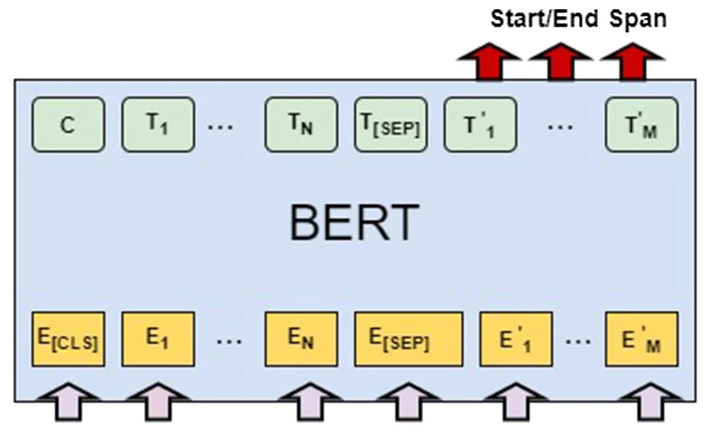

In [ ]:
from transformers import BertForQuestionAnswering, BertTokenizer
import torch

# Load the pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')

# Set the device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/443 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForQuestionAnswering(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((1024,)

In [ ]:
# Sample context and question
context = "BERT is a model that has been fine-tuned on a variety of tasks including question answering, named entity recognition, and text classification."
question = "What tasks has BERT been fine-tuned on?"

In [ ]:
# Encode the context and question
inputs = tokenizer.encode_plus(question, context, return_tensors='pt')
input_ids = inputs['input_ids']
attention_mask = inputs['attention_mask']

# Get the scores for the start and end of the answer
outputs = model(input_ids=input_ids, attention_mask=attention_mask)
start_scores = outputs.start_logits
end_scores = outputs.end_logits

In [ ]:
print('start scores by idx:', start_scores.tolist())
print('end scores by idx:', end_scores.tolist())

start scores by idx: [[-6.33481502532959, -6.010531425476074, -8.261150360107422, -7.816985607147217, -7.691162109375, -8.038551330566406, -7.638827323913574, -8.283190727233887, -8.092428207397461, -7.530564308166504, -8.568913459777832, -6.334770202636719, -2.152738571166992, -6.714320182800293, -5.0549116134643555, -4.079789161682129, -6.674471855163574, -4.730399131774902, -5.041072368621826, -3.1599297523498535, -7.047946929931641, -5.325677871704102, -3.1021149158477783, -0.5008115768432617, -2.660747528076172, -5.997541427612305, -1.467658281326294, -0.08949583768844604, 7.320633888244629, 0.10648027062416077, -3.6740293502807617, -0.49088338017463684, -3.231414318084717, -2.9671835899353027, -5.567190170288086, -4.589102745056152, -2.047222137451172, -2.6916115283966064, -5.304234027862549, -6.334765434265137]]
end scores by idx: [[-1.2116094827651978, -5.170655250549316, -7.6252031326293945, -6.636591911315918, -7.183358192443848, -7.083223342895508, -7.72733211517334, -7.3528

In [ ]:
# visualize scores with heatmap, using seaborn
import seaborn as sns
sns.heatmap(start_scores.tolist(), cmap='coolwarm')

In [ ]:
sns.heatmap(end_scores.tolist(), cmap='coolwarm')

In [ ]:
# Get the most likely start and end token indices
# DIY
start_index = None # Your code here
end_index = None # Your code here
print('start index:', start_index)
print('end index:', end_index)

start index: tensor(28)
end index: tensor(37)


In [ ]:
# Convert the token indices back to the original text
answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[0][start_index:end_index+1]))

print(f"Question: {question}")
print(f"Answer: {answer}")

Question: What tasks has BERT been fine-tuned on?
Answer: question answering , named entity recognition , and text classification
